# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random
from IPython.display import display, clear_output
import bayes_opt

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from UTILITY_plotNMM import plotNMM, slicePlotNMM
from UTILITY_linacPhaseAndAmplitude import getLinacMatchStrings, setLinacPhase, setLinacGradientAuto
from UTILITY_modifyAndSaveInputBeam import modifyAndSaveInputBeam
from UTILITY_setLattice import setLattice

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

#Need to explicitly add non-MARKER places to save beam...
tao.cmd("set beam add_saved_at = DTOTR")

[]

In [3]:
tao.cmd("show ele L0AFEND")

['Element # 37',
 'Element Name: L0AFEND',
 'Key: Marker',
 'S_start, S:      4.127448,      4.127448',
 'Ref_time_start, Ref_time:  1.378376E-08,  1.378376E-08',
 '',
 'Attribute values [Only non-zero values shown]:',
 '    1  L                           =  0.0000000E+00 m',
 '    7  OSC_AMPLITUDE               =  0.0000000E+00 m',
 '   24  TILT_CALIB                  =  0.0000000E+00 rad',
 '   25  DE_ETA_MEAS                 =  0.0000000E+00',
 '   53  P0C                         =  6.3997960E+07 eV           BETA                        =  9.9996812E-01',
 '   54  E_TOT                       =  6.4000000E+07 eV           GAMMA                       =  1.2524488E+02',
 '   64  REF_TIME_START              =  1.3783756E-08 sec      50  DELTA_REF_TIME              =  0.0000000E+00 sec',
 '',
 '       TRACKING_METHOD              =  Bmad_Standard             APERTURE_AT                =  Exit_End',
 '       MAT6_CALC_METHOD             =  Auto                      APERTURE_TYPE          

# Beam construction

## Import beam

In [4]:
lastTrackedElement = "BEGBC20"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')
#Can see present track_start and track_end values with `show beam`


#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [5]:
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_noInjectorMatch.h5'

modifyAndSaveInputBeam(inputBeamFilePath) #Do nothing to the imported beam

#Set lattice to my latest default config
setLattice(tao)

tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


[]

In [6]:
print(tao.bunch_params("L0AFEND")['twiss_beta_x'])
print(tao.bunch_params("L0AFEND")['twiss_alpha_x'])

print(tao.bunch_params("L0AFEND")['twiss_beta_y'])
print(tao.bunch_params("L0AFEND")['twiss_alpha_y'])

19.6168878207781
-1.96383176903741
19.6634321992183
-1.97022914191995


In [7]:
PBEGBC20 =  ParticleGroup(data=tao.bunch_data("BEGBC20"))

"""
sigmaX = PBEGBC20.std("x")
sigmaY = PBEGBC20.std("y")
sigmaZ = PBEGBC20.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z

print(f"{sigmaX}, {sigmaY}, {sigmaZ}")
"""

print(f"{1e6*PBEGBC20.norm_emit_x}, {1e6*PBEGBC20.norm_emit_y}")

11.11427494442546, 7.108815541961159


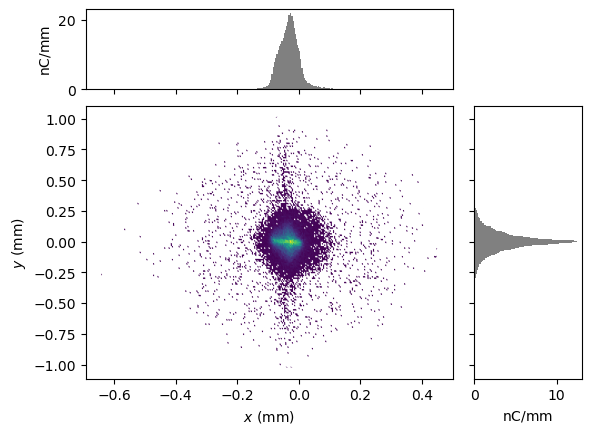

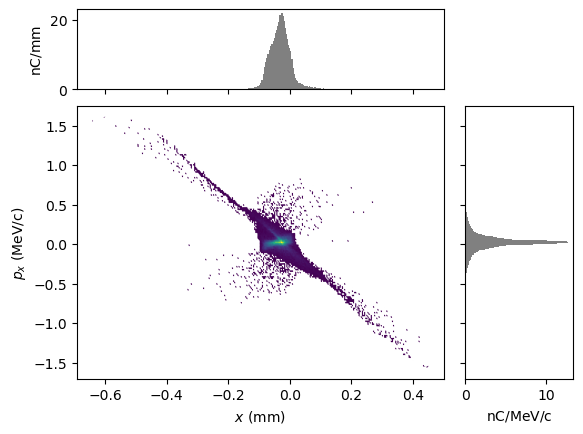

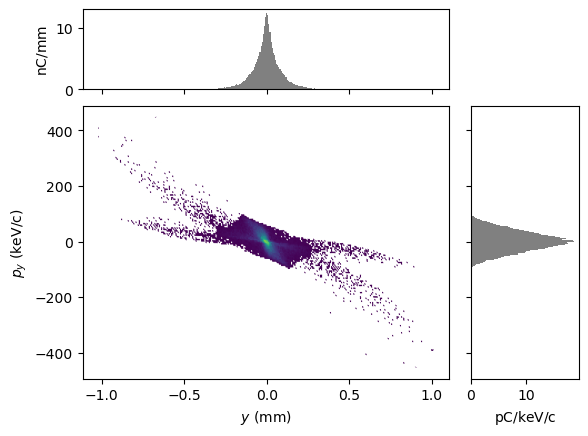

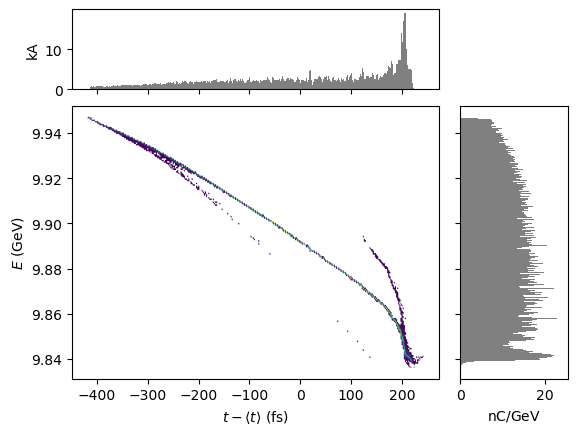

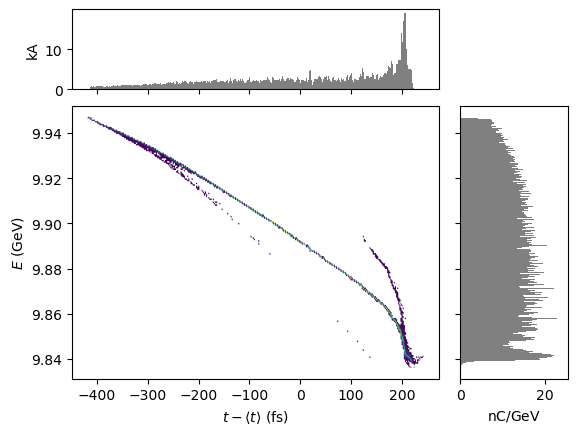

In [8]:
display(plotNMM(PBEGBC20, 'x', 'y',  bins=300))
display(plotNMM(PBEGBC20, 'x', 'px',  bins=300))
display(plotNMM(PBEGBC20, 'y', 'py',  bins=300))
display(plotNMM(PBEGBC20, 'delta_t', 'energy',  bins=300))

In [9]:
#Using values from 2024-05-16 "2024-05-16_optimizeLaunch_driverToBEGBC20_v2"
#launchBetaX     3.434759e+01
#launchAlphaX   -4.055899e-01
#launchBetaY     5.065692e+01
#launchAlphaY   -2.618756e+00
#finalEmitX      5.860816e-06
#finalEmitY      6.099057e-06

modifyAndSaveInputBeam(
    inputBeamFilePath,
    betaX = 3.434759e+01,
    alphaX = -4.055899e-01,
    betaY = 5.065692e+01,
    alphaY = -2.618756e+00
    #numMacroParticles = 10000
)

tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [10]:
print(tao.bunch_params("L0AFEND")['twiss_beta_x'])
print(tao.bunch_params("L0AFEND")['twiss_alpha_x'])

print(tao.bunch_params("L0AFEND")['twiss_beta_y'])
print(tao.bunch_params("L0AFEND")['twiss_alpha_y'])

33.2520060506873
-0.405561620454059
49.0423309997888
-2.61875869795335


In [11]:
PBEGBC20 =  ParticleGroup(data=tao.bunch_data("BEGBC20"))

"""
sigmaX = PBEGBC20.std("x")
sigmaY = PBEGBC20.std("y")
sigmaZ = PBEGBC20.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z

print(f"{sigmaX}, {sigmaY}, {sigmaZ}")
"""

print(f"{1e6*PBEGBC20.norm_emit_x}, {1e6*PBEGBC20.norm_emit_y}")

6.135268017137544, 6.2941406394083135


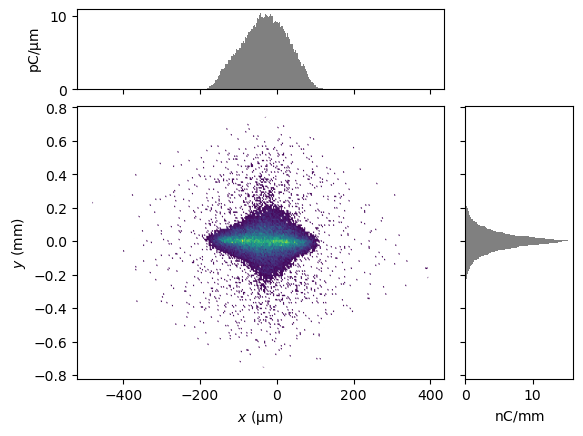

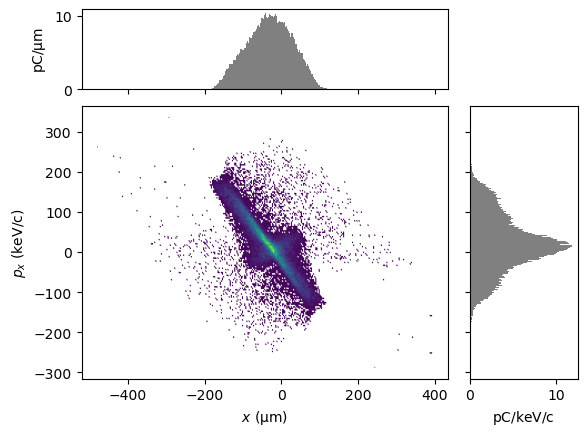

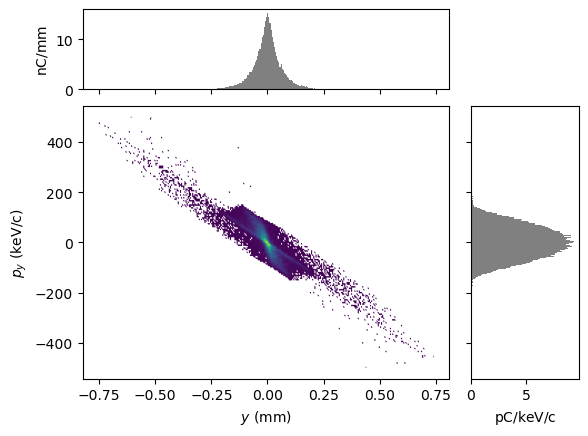

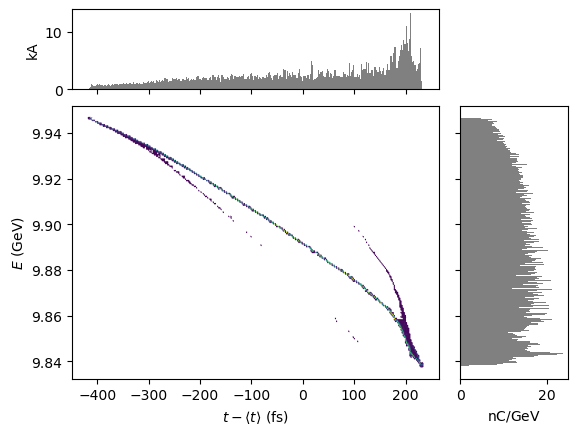

In [12]:
display(plotNMM(PBEGBC20, 'x', 'y',  bins=300))
display(plotNMM(PBEGBC20, 'x', 'px',  bins=300))
display(plotNMM(PBEGBC20, 'y', 'py',  bins=300))
display(plotNMM(PBEGBC20, 'delta_t', 'energy',  bins=300))

In [13]:
outputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5'
P = ParticleGroup(data=tao.bunch_data("L0AFEND"))
P.write(outputBeamFilePath)

In [14]:
P

<ParticleGroup with 76267 particles at 0x31f4c34d0>

In [15]:
def propagateToMFFF(): #From the more general modifyLaunchBeamAndPropagateToMFFF(...)

    ######################################################################################
    #First import "clean" beam and do modification at launch point
    ######################################################################################

    inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly.h5'

    tao.cmd('reinit beam')

    P = modifyAndSaveInputBeam(
        inputBeamFilePath,
        numMacroParticles = 5000,
        #betaX = launchBetaX,
        #alphaX = launchAlphaX,
        #betaY = launchBetaY,
        #alphaY = launchAlphaY
    )

    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')
    inputBeamFilePath = f'{filePath}/bmad/beams/activeBeamFile.h5'

    ##################################
    #Propagate to MFFF and save result
    ##################################
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "MFFF"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
    tao.cmd('reinit beam')

    tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
    tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    P.write(f'{filePath}/bmad/beams/activeBeamFile.h5')

    return

In [16]:
def prepareToSimulateFromMFFFtoEnd():
    #####################################################
    #Import the MFFF beam and prepare to simulate to end
    #####################################################
    tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
    tao.cmd(f'set beam_init track_start = MFFF')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    return

In [17]:
def specificOptimizer(
    self,
    **kwargs
):
    

    badValue = -1 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue

    try:
        propagateToMFFF()
        prepareToSimulateFromMFFFtoEnd()
        #tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        #tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue

    try:
        tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue

    DTOTRSigmaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_beta_x']
    
    try:
        tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

    except:
        return badValue
    
    DTOTRSigmaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_sigma_x']
    DTOTRBetaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_beta_x']


    maximizeMe = DTOTRSigmaXValTCAVOn / DTOTRSigmaXValTCAVOff
 
    
    
    #Collect desired data as a pandas Series
    tmpData = pd.Series(
        
        kwargs | { #The pipe joins dictionaries 
        #"L1PhaseSet": L1PhaseSet,
        #"L2PhaseSet": L2PhaseSet,
        #"L2EnergyOffset": L2EnergyOffset,
        #"L3EnergyOffset": L3EnergyOffset,
        "XTCAVBetaX": tao.bunch_params("DTOTR")['twiss_beta_x'],
        "DTOTRSigmaXValTCAVOn": DTOTRSigmaXValTCAVOn,
        "DTOTRSigmaXValTCAVOff": DTOTRSigmaXValTCAVOff,
        "DTOTRBetaXValTCAVOn": DTOTRBetaXValTCAVOn,
        "DTOTRBetaXValTCAVOff": DTOTRBetaXValTCAVOff,
        "maximizeMe": maximizeMe
    #   "finalEmit": finalEmit,
    #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
    #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    #    "fig": outputFig
    })

    
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()
    
    return maximizeMe



def optimizerWrapper( self, L1PhaseSet, L2PhaseSet, Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG, **kwargs ):
    return specificOptimizer(
        self,
        **{
            "L1PhaseSet": L1PhaseSet, 
            "L2PhaseSet": L2PhaseSet,
            "Q5FFkG": Q5FFkG,
            "Q4FFkG": Q4FFkG,
            "Q3FFkG": Q3FFkG,
            "Q2FFkG": Q2FFkG,
            "Q1FFkG": Q1FFkG,
            "Q0FFkG": Q0FFkG,
            "Q0DkG": Q0DkG,
            "Q1DkG": Q1DkG,
            "Q2DkG": Q2DkG,
        }
    )

In [18]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()

    def updatePlot(self):
        plotKey = "maximizeMe"
        
        # Clear the previous figure to prevent flickering
        clear_output(wait=True)
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        #plt.plot(self.history.index, self.history['finalEmit'], '-o', markersize=8)
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        # Show plot
        plt.show()


# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()



def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
    
# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
pbounds = {
    #'L1PhaseSet': (-30, 10),
    #'L2PhaseSet': (-60, 10),
    'L1PhaseSet': makeBoundsTuple(0.2, -30),
    'L2PhaseSet': makeBoundsTuple(0.2, -45),
    #'L2EnergyOffset': (-200e6, 200e6),
    #'L3EnergyOffset': (-200e6, 200e6),
    
    #Full SCP ranges
    'Q5FFkG': (-256, 0), 
    'Q4FFkG': (-446, 0), 
    'Q3FFkG': (0, 457),
    'Q2FFkG': (0, 167),
    'Q1FFkG': (-257, 0),
    'Q0FFkG': (0, 167),
    'Q0DkG': (-239, 0),
    'Q1DkG': (0, 386),
    'Q2DkG': (-223, 0),

    #'Q5FFkG': makeBoundsTuple(0.2, -70), 
    #'Q4FFkG': makeBoundsTuple(0.2, -70),
    #'Q3FFkG': makeBoundsTuple(0.2, 106),
    #'Q2FFkG': makeBoundsTuple(0.2, 112),
    #'Q1FFkG': makeBoundsTuple(0.2, -224),
    #'Q0FFkG': makeBoundsTuple(0.2, 112),
    #'Q0DkG':  makeBoundsTuple(0.2, -115),
    #'Q1DkG':  makeBoundsTuple(0.2, 180),
    #'Q2DkG':  makeBoundsTuple(0.2, -115),

}

optimizer = bayes_opt.BayesianOptimization(
    f=problem.optimizerWrapper,
    pbounds=pbounds,
    random_state=2,
    allow_duplicate_points=True #2024-04-26 it was whining about this 
)

#Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
#and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
boInitialKappa = 10.
boFinalKappa = 0.1
boNumIter = 500
boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
                                   kappa=boInitialKappa,         #Default 2.576
                                   xi=0.0,              #Default 0
                                   kappa_decay=boKappaDecay,       #Default 0
                                   kappa_decay_delay=0  #Default 0                     
                                          )


optimizer.maximize(
    init_points=0, #Initial, random points
    n_iter=boNumIter,
    acquisition_function=acquisition_function
)


#print(res)
print(problem.history) 

|   iter    |  target   | L1Phas... | L2Phas... |   Q0DkG   |  Q0FFkG   |   Q1DkG   |  Q1FFkG   |   Q2DkG   |  Q2FFkG   |  Q3FFkG   |  Q4FFkG   |  Q5FFkG   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -1.0      | -30.77    | -53.53    | -107.6    | 72.7      | 162.3     | -172.1    | -177.4    | 103.4     | 136.9     | -327.0    | -96.99    |
| 2         | -1.0      | -33.28    | -44.96    | -152.5    | 145.8     | 374.6     | -33.36    | -40.47    | 32.51     | 79.64     | -265.5    | -103.8    |
| 3         | -1.0      | -36.0     | -36.0     | -239.0    | 167.0     | 0.0       | -257.0    | 0.0       | 0.0       | 457.0     | 0.0       | 0.0       |
| 4         | -1.0      | -31.29    | -54.0     | 0.0       | 0.0       | 386.0     | 0.0       | -223.0    | 167.0     | 457.0     | -4.216e-1 | -256.0    |
| 5         | -1.0      | -25.39    | -36.0     | 0.

In [19]:
problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)
problem.history.to_csv('output_data.csv', index=False)

bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 

#Using triple quotes lets us use " inside the f-string
#print(f"""\n{1e6*bestConfigData["sigmaX"]}, {1e6*bestConfigData["sigmaY"]}, {1e6*bestConfigData["sigmaZ"]}""")


setLattice(tao, **bestConfigDict)



tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))



KeyError: 'maximizeMe'

In [ ]:
display(plotNMM(PPENT, 'x', 'y',  bins=300))
display(plotNMM(PPENT, 'x', 'pz', bins=300))
display(plotNMM(PPENT, 'delta_t', 'pz', bins=300))
display(slicePlotNMM(PPENT, 'norm_emit_x',n_slice=100))

In [ ]:
elements=tao.lat_ele_list();


floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)


#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,50000])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=978
zmax=1016.162829 #DTOTR S = 1016.162829

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

In [ ]:
tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


PTCAVOn = ParticleGroup(data=tao.bunch_data("DTOTR"))


tao.cmd("set ele XTCAVF VOLTAGE = 0")
tao.cmd("set ele XTCAVF PHI0 = 0")
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation


PTCAVOff = ParticleGroup(data=tao.bunch_data("DTOTR"))

In [ ]:
display(plotNMM(PTCAVOn, 'x', 'y', bins=300))
display(plotNMM(PTCAVOff, 'x', 'y', bins=300))

In [ ]:
PTCAVOn[PTCAVOn.status==1]

In [ ]:
PTCAVOff[PTCAVOff.status==1]